In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

import helper_functions as hlp
import function_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import plot_function_gradcam as pgc

print("TF  Version",tf.__version__)

TF  Version 2.4.0


## Load Data

In [2]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
DATA_DIR = "/tf/notebooks/brdd/xAI_3d/data/"

WEIGHT_DIR = "/tf/notebooks/brdd/xAI_3d/weights/10Fold/"
OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/pictures/10Fold/"
pic_save_name = "10Fold_ensembling"

# WEIGHT_DIR = "/tf/notebooks/brdd/xAI_3d/weights/andrea_split/"
# OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/pictures/andrea_split/"
# pic_save_name = "andrea_split"

def generate_model_name(which_split, model_nr, path):
    return (path + "3d_cnn_binary_model_split" + str(which_split) + 
              "_unnormalized_avg_layer_paper_model_sigmoid_activation_1" + str(model_nr) + ".h5")

/tf/notebooks/brdd/xAI_3d


In [3]:
## load images and ids

# ## for andrea
# with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
#     # with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
#     # both images are the same
#         X_in = h5["X"][:]
#         pat = h5["pat"][:]

## for 10 Fold       
id_tab = pd.read_csv(DATA_DIR + "10Fold_ids.csv", sep=",")
pat = id_tab["p_id"].to_numpy()
X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")

## load results
path_results = DATA_DIR + "all_tab_results_10Fold.csv" # 10 Fold
# path_results = DATA_DIR + "all_tab_results_andrea_split.csv" # andrea split
all_results = pd.read_csv(path_results, sep=",")
all_results = all_results.sort_values("p_idx")

In [4]:
split_6_pats = [297, 299, 319, 460, 483, 529, 27, 35, 125, 481]

In [5]:
all_results["y_pred_std"] = all_results[["y_pred_model_1" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

[Text(0.5, 0, 'true class'), Text(0, 0.5, 'prediction uncertainty')]

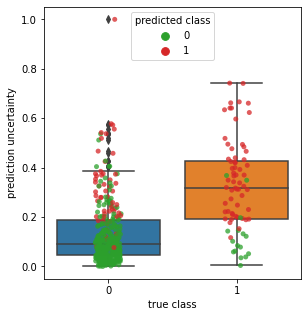

In [6]:
# Plot uncertainty
import seaborn as sns
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

<AxesSubplot:xlabel='pred_ok', ylabel='y_pred_unc'>

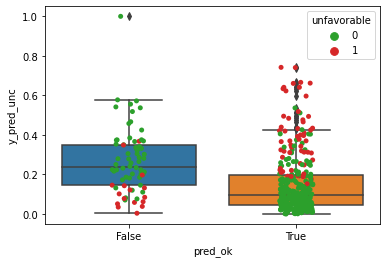

In [7]:
all_results["pred_ok"] = all_results["y_pred_class"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_ok",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_ok",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

<AxesSubplot:xlabel='y_pred_trafo_avg', ylabel='y_pred_unc'>

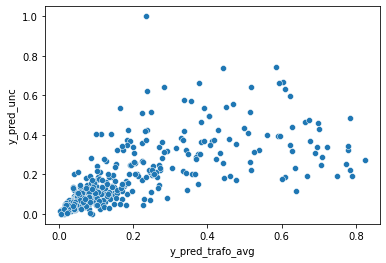

In [8]:
sns.scatterplot(
           x = "y_pred_trafo_avg",
           y = "y_pred_unc",
            data = all_results)

## Model

In [9]:
# define model
layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

input_dim = (128, 128, 28, 1)
output_dim = 1
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


## Function to calculate GradCam heatmap of ensemble and to Plot

In [10]:
from functions_gradcam import multi_layers_grad_cam_3d
def multi_models_grad_cam_3d(img, cnn, model_names, layers, mode = "mean"):
    valid_modes = ["mean", "median", "max"]
    if mode not in valid_modes:
        raise ValueError("multi_models_grad_cam_3d: mode must be one of %r." % valid_modes)
        
    if not isinstance(layers, list):
        layers = [layers]
    
    h_l = []
    for model_name in model_names:
        cnn.load_weights(model_name)
        heatmap, resized_img = multi_layers_grad_cam_3d(img = img, model_3d = cnn , layers = layers)
        h_l.append(heatmap)
    
    h_l = np.array(h_l)
    if mode == "mean":
        heatmap = np.mean(h_l, axis = 0)
    elif mode == "median":
        heatmap = np.median(h_l, axis = 0)
    elif mode == "max":
        heatmap = np.max(h_l, axis = 0)
        
    return heatmap, resized_img


def get_img_and_models(p_ids, results, pats, imgs):
    imgs = np.expand_dims(imgs, axis = -1)
    
    # extract table with all matches for p_ids
    res_tab = results[results.p_id.isin(p_ids)].sort_values(["p_id", "test_split"]).reset_index()
    
    res_imgs = []
    res_mod_names = []
    
    res_test_splits = list(res_tab.test_split)
    for i, p_id in enumerate(list(res_tab.p_id)):
        index = np.argwhere(pat == p_id).squeeze()
        res_imgs.append(imgs[index])
        
        # generate model names
        res_mod_names.append(
            [generate_model_name(res_test_splits[i], j, WEIGHT_DIR) for j in range(5)]
        )
            
    return (res_tab, np.array(res_imgs), res_mod_names)

def plot_gradcams_last_avg_org(res_table, vis_layers, res_images, res_model_names, 
                               layer_mode, heatmap_mode, save_path, save_name, save = True):
    
    for j in range(len(res_table)):   
        plot_per_iter = 1
        plot_at_end = 1
        layer_iter = 1 #len(vis_layers)
        num_rows = layer_iter*plot_per_iter + plot_per_iter + plot_at_end
        width = 15

        start_text = 0.08
        end_text = 0.89
        text_pos = np.flip(np.linspace(
            start_text+(plot_at_end/num_rows)+0.2/(num_rows-plot_at_end), 
            end_text-0.2/(num_rows-plot_at_end), 
            layer_iter+1))

        fig = plt.figure(figsize = (width,num_rows*width/3))

        plt.gcf().text(0.14, end_text+3/num_rows/18, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
        plt.gcf().text(0.14, end_text+2/num_rows/18, "true_mrs:    " + str(round(res_table["mrs"][j])), fontsize=16)
        plt.gcf().text(0.14, end_text+1/num_rows/18, "true class:  " + str(res_table["unfavorable"][j]), fontsize=16)
        plt.gcf().text(0.4, end_text+3/num_rows/18, "pred class:          " + str(res_table["y_pred_class"][j]), fontsize=16)
        plt.gcf().text(0.4, end_text+2/num_rows/18, "pred prob (class 1): " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
        plt.gcf().text(0.4, end_text+1/num_rows/18, "pred uncertainty:    " + str(round(res_table["y_pred_unc"][j], 3)), fontsize=16)


        # last layer
        plt.gcf().text(0.1, text_pos[0], "Layer: " + vis_layer, 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)

        heatmap, resized_img = multi_models_grad_cam_3d(
                img = res_images[j:j+1], 
                cnn = model_3d,
                model_names = res_model_names[j],
                layers = vis_layers[-1],
                mode = layer_mode)

        pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = heatmap_mode,
                add_plot = (0,num_rows),
                show = False)


        # average over all layers
        heatmap, resized_img = multi_models_grad_cam_3d(
                img = res_images[j:j+1], 
                cnn = model_3d,
                model_names = res_model_names[j],
                layers = vis_layers,
                mode = layer_mode)

    #     print(layer_mode, "over all Layers")
        plt.gcf().text(0.1, text_pos[-1], layer_mode + " over all Layers", 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
        pgc.plot_gradcam(resized_img, heatmap,
                    version = "overlay",
                    mode = heatmap_mode,
                    add_plot = (1,num_rows),
                    show = False)

    #     print("Original")
        plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
        pgc.plot_gradcam(resized_img, heatmap,
                    version = "original",
                    mode = heatmap_mode,
                    add_plot = (num_rows-1,num_rows),
                    show = False)

        plt.subplots_adjust(wspace=0.05, hspace=0.15)
        if save:
            plt.savefig(save_path + 'pat' + str(round(res_table["p_id"][j])) + '_' + 
                        save_name + '_last_and_all_layers_' + heatmap_mode + '.png')
    

# Plot GradCams

## Compare one Model to all Models

In [11]:
# select patient
p_ids = [460]
(res_table, res_images, res_model_names) = get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in)
res_table

index  p_idx  p_id  mrs  unfavorable  fold0 fold1  fold2  fold3  fold4  \
0    277    324   460  4.0            1  train   val  train  train  train   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.158609        0.176578         0.10357          0.158659   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  pred_ok  
0         0.155143   0.225797             0    0.040255    0.121997    False  

[1 rows x 28 columns]

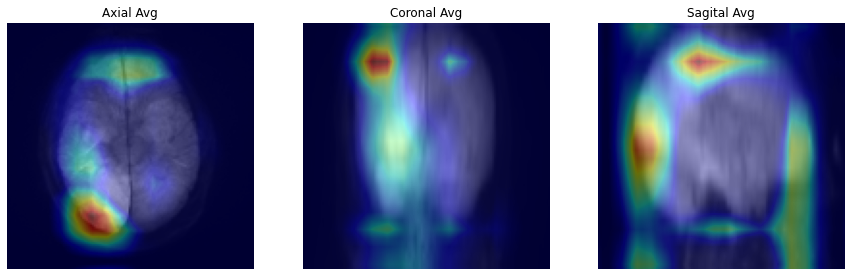

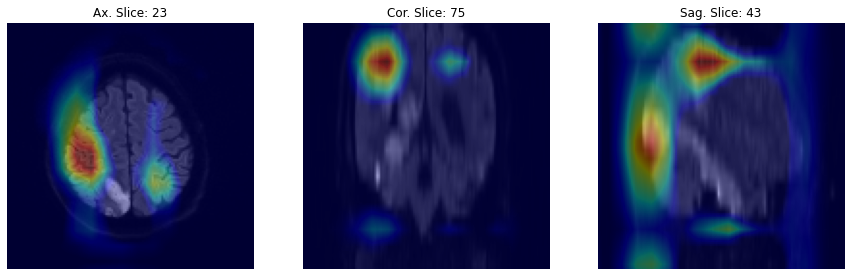

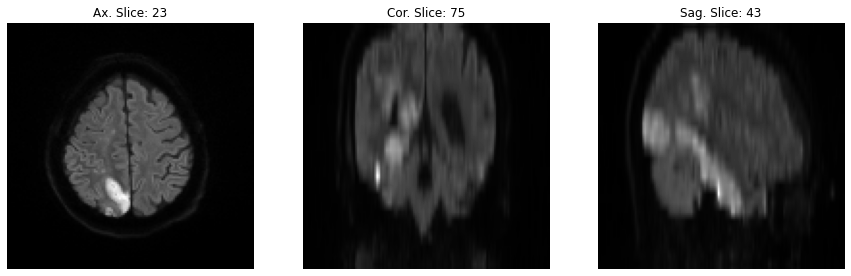

In [12]:
# only one model
heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][4]],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

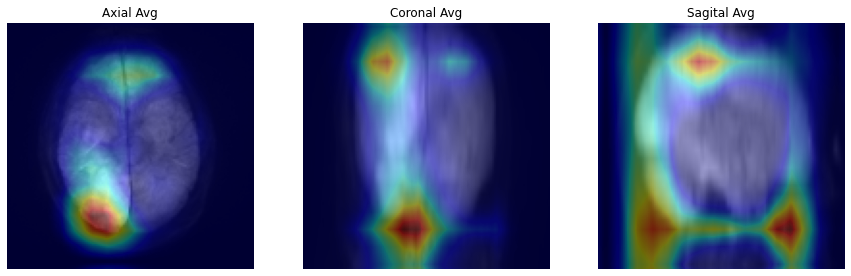

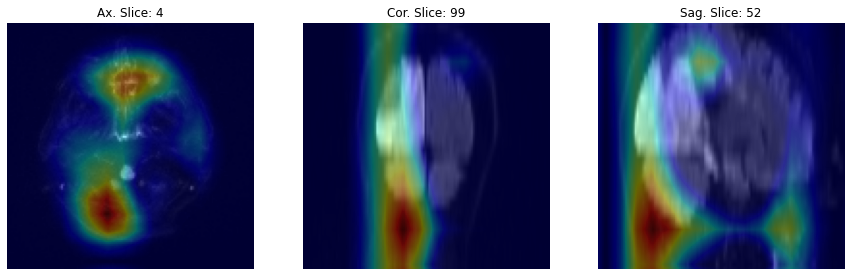

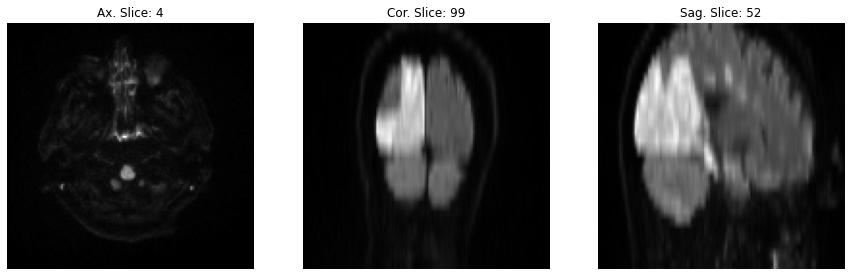

In [13]:
# all models
heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

## Plot multiple Layers

In [14]:
# select patient
p_ids = [460]
(res_table, res_images, res_model_names) = get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in)
res_table

index  p_idx  p_id  mrs  unfavorable  fold0 fold1  fold2  fold3  fold4  \
0    277    324   460  4.0            1  train   val  train  train  train   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.158609        0.176578         0.10357          0.158659   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  pred_ok  
0         0.155143   0.225797             0    0.040255    0.121997    False  

[1 rows x 28 columns]

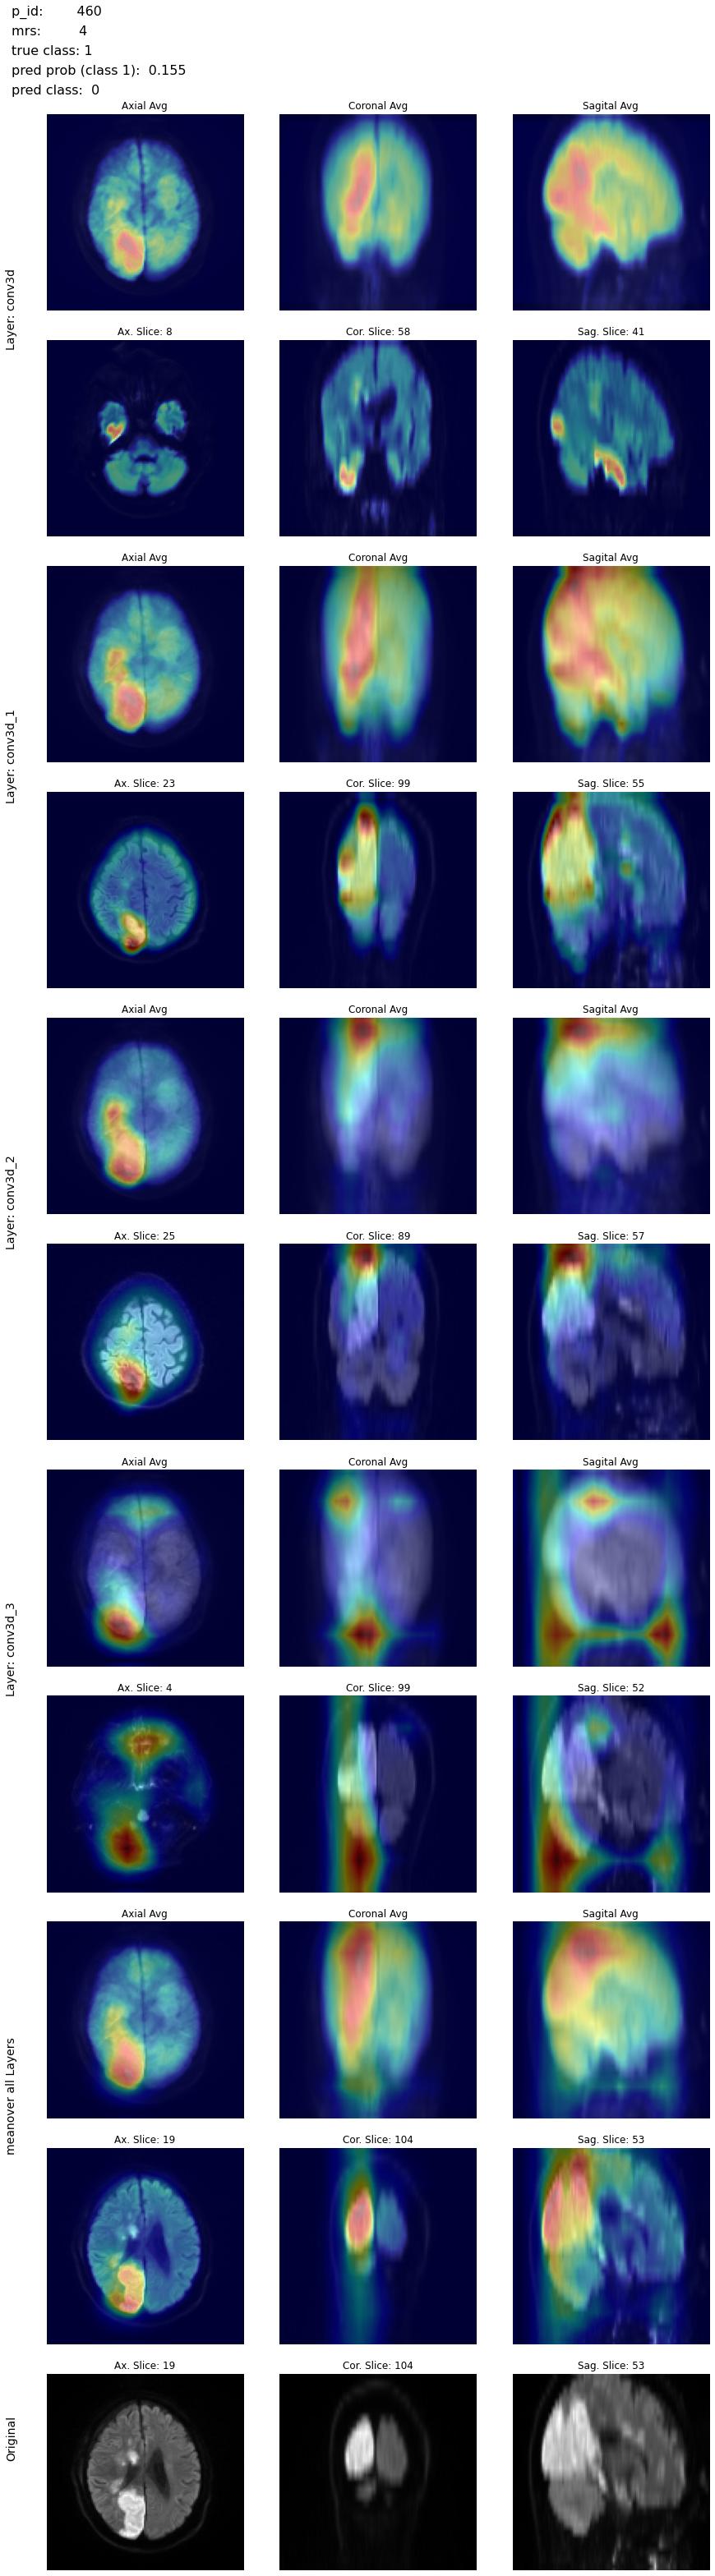

In [15]:
layer_mode = "mean"

vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

for j in range(len(res_table)):   
    plot_per_iter = 2
    plot_at_end = 1
    num_rows = len(vis_layers)*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.12
    end_text = 0.88
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.6/(num_rows-plot_at_end), 
        end_text-0.6/(num_rows-plot_at_end), 
        len(vis_layers)+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+5/num_rows/15, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+4/num_rows/15, "mrs:         " + str(round(res_table["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+3/num_rows/15, "true class: " + str(res_table["unfavorable"][j]), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/15, "pred prob (class 1):  " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/15, "pred class:  " + str(res_table["y_pred_class"][j]), fontsize=16)

    for i, vis_layer in enumerate(vis_layers):
#         print("Layer: ", vis_layer)
        plt.gcf().text(0.1, text_pos[i], "Layer: " + vis_layer, 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
        heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layer,
            mode = layer_mode)
        
        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "avg",
                     add_plot = (i*2,num_rows),
                     show = False)
        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "max",
                     add_plot = (i*2+1,num_rows),
                     show = False)
        
    # average over all layers
    heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers,
            mode = layer_mode)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + "over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                add_plot = (num_rows-3,num_rows),
                show = False)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "max",
                add_plot = (num_rows-2,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "max",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.savefig('pictures/p' + str(round(res_table["p_id"][j])) + '_' + pic_save_name + '_all_conv_layers.png')


## Plot last conv and average of conv layer

Same style as PowerPoint

In [16]:
all_results

p_idx  p_id  mrs  unfavorable  fold0  fold1  fold2  fold3  fold4  fold5  \
205      1     1  1.0            0    val  train  train  train  train   test   
206      2     2  1.0            0    val  train  train  train  train   test   
367      3     3  0.0            0  train  train  train  train    val  train   
41       4     5  0.0            0  train   test  train  train  train  train   
246      5     6  3.0            1  train    val  train  train  train  train   
..     ...   ...  ...          ...    ...    ...    ...    ...    ...    ...   
81     403   555  0.0            0  train   test  train  train  train  train   
122    404   556  0.0            0  train  train   test  train  train  train   
406    405   557  1.0            0  train  train  train  train    val  train   
366    406   559  1.0            0  train  train  train    val  train  train   
40     407   563  0.0            0   test  train  train  train  train    val   

     ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
205  ...        0.006181        0.013081        0.010683          0.014991   
206  ...        0.024134        0.049767        0.028247          0.041919   
367  ...        0.131908        0.243230        0.315786          0.214386   
41   ...        0.716669        0.567527        0.606706          0.632576   
246  ...        0.245842        0.348741        0.214166          0.255132   
..   ...             ...             ...             ...               ...   
81   ...        0.149574        0.192147        0.250651          0.175050   
122  ...        0.005053        0.002783        0.005456          0.005471   
406  ...        0.017014        0.018259        0.032513          0.021741   
366  ...        0.382177        0.497345        0.451610          0.383389   
40   ...        0.162804        0.116230        0.112661          0.136019   

     y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  \
205          0.012591   0.225797             0    0.011203    0.023175   
206          0.037599   0.225797             0    0.023930    0.066466   
367          0.204826   0.225797             0    0.080713    0.259615   
41           0.635252   0.225797             1    0.073403    0.234749   
246          0.251216   0.225797             1    0.062966    0.199249   
..                ...        ...           ...         ...         ...   
81           0.171000   0.225797             0    0.048992    0.151715   
122          0.004206   0.225797             0    0.004389    0.000000   
406          0.021154   0.225797             0    0.006223    0.006235   
366          0.379666   0.225797             1    0.094181    0.305426   
40           0.133330   0.225797             0    0.033827    0.100132   

     pred_ok  
205     True  
206     True  
367     True  
41     False  
246     True  
..       ...  
81      True  
122     True  
406     True  
366    False  
40      True  

[407 rows x 27 columns]

In [17]:
# select patient
# p_ids = [6]
p_ids = split_6_pats

(res_table, res_images, res_model_names) = get_img_and_models(
    p_ids, results = all_results[all_results.test_split == 6], pats = pat, imgs = X_in) # andrea split
# (res_table, res_images, res_model_names) = get_img_and_models(
# p_ids, results = all_results, pats = pat, imgs = X_in) # 10 Fold

res_table[["p_id", "mrs", "unfavorable", "test_split", "y_pred_model_10", 
           "y_pred_model_11", "y_pred_model_12", "y_pred_model_13", "y_pred_model_14", 
           "y_pred_trafo_avg", "threshold", "y_pred_class", "y_pred_unc"]].to_csv(
    OUTPUT_DIR + "andrea_split6_meta_data.csv",  index=False)

In [18]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

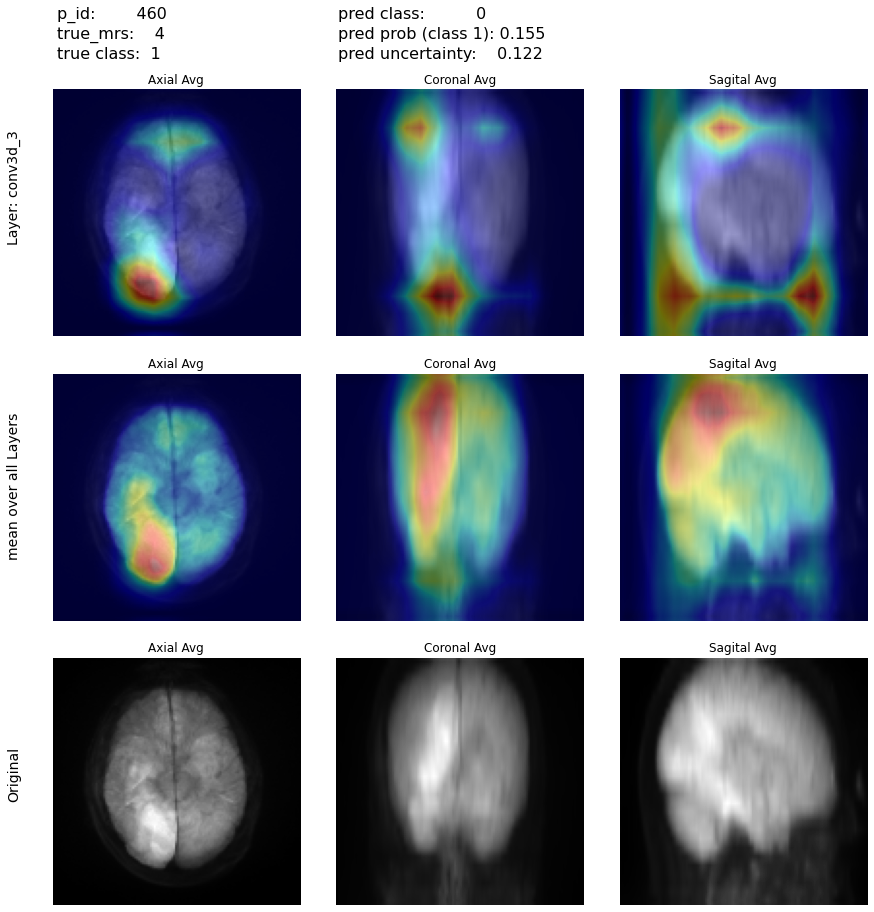

In [19]:
plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    layer_mode = "mean", 
    heatmap_mode = "avg", 
    save_path = OUTPUT_DIR, 
    save_name = pic_save_name, save = True)

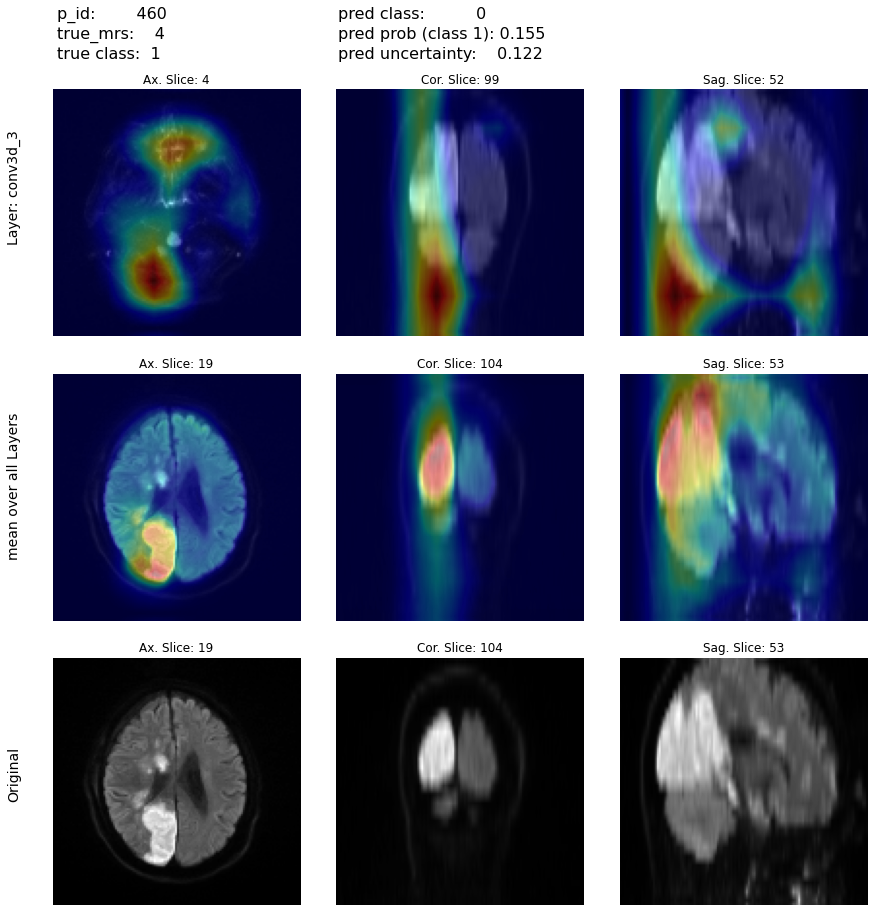

In [20]:
plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    layer_mode = "mean", 
    heatmap_mode = "max", 
    save_path = OUTPUT_DIR, 
    save_name = pic_save_name, save = True)

## Analysis of Patients in multiple splits

In [21]:
all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
all_dup

Empty DataFrame
Columns: [p_idx, p_id, mrs, unfavorable, fold0, fold1, fold2, fold3, fold4, fold5, fold6, fold7, fold8, fold9, test_split, y_pred_model_10, y_pred_model_11, y_pred_model_12, y_pred_model_13, y_pred_model_14, y_pred_linear_avg, y_pred_trafo_avg, threshold, y_pred_class, y_pred_std, y_pred_unc, pred_ok]
Index: []

[0 rows x 27 columns]

In [22]:
p_ids = [9,24]

In [23]:
(res_table, res_images, res_model_names) = get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in)

In [24]:
res_table

index  p_idx  p_id  mrs  unfavorable  fold0  fold1  fold2  fold3  fold4  \
0    164      7     9  0.0            0  train  train  train  train   test   
1    288     17    24  2.0            0  train  train    val  train  train   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.059622        0.125420        0.072176          0.077219   
1  ...        0.073408        0.152778        0.082404          0.097183   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  pred_ok  
0         0.066266   0.225797             0    0.041363    0.125766     True  
1         0.093217   0.225797             0    0.034951    0.103954     True  

[2 rows x 28 columns]

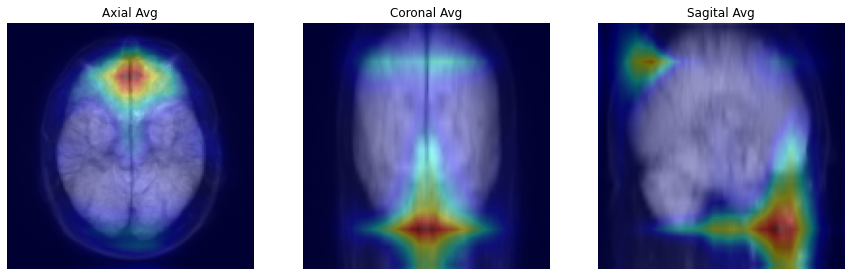

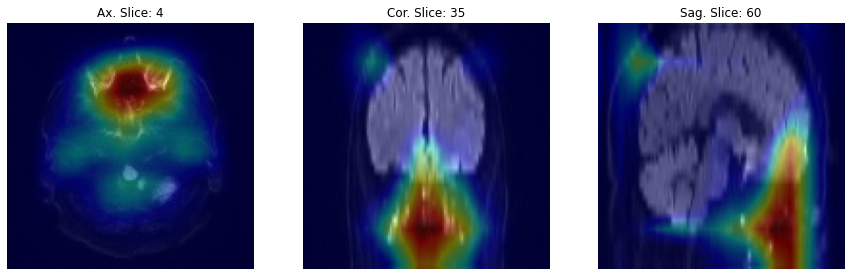

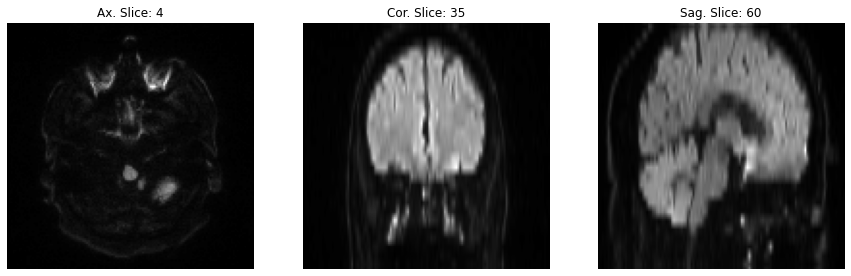

In [25]:
heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[1], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[1],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")